#MP4

In this assignment you will be performing Semantic Segmentation. We've provided the dataset and some helper code to guide you along.

Reminders:
- When first getting your code to run do not use GPU as this will exhaust your colab resources
- When you're ready to properly test your models, make sure you are connected to a GPU runtime as this does significantly speeds up execution
    - To change your runtime do: **Runtime** --> **Change runtime type** --> under **Hardware accelerator** select **GPU**
    - Note that changing runtime resets your kernel (meaning you will need to rerun cells and local variables will be lost)
    - It also sets this new runtime as the default when you return to this notebook later
- Do not start last minute, these models do take some time to train
- Loading the data takes some time, you should only have to do this once

## Accessing the data

There are multiple ways to work with data in colab.
See this [Colab notebook](https://colab.research.google.com/notebooks/io.ipynb) or this [StackOverflow post](https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive) for more details.

Once you've mounted your drive you can see your entire drive file structure by clicking the "Files" tab on the left.

**If you wish to work locally you can ignore the first two cells, but you will still need to set the appropriate path for your dataset**

In [1]:
# # Note there are other methods to do this
from google.colab import drive
drive.mount('/content/gdrive/')

import os

BASE_PATH = "/content/gdrive/My Drive/Colab Notebooks/CS_498_MP4/"
DATASET_PATH = os.path.join(BASE_PATH, "sbd/")
IMG_PATH = os.path.join(BASE_PATH, "imgs/")
MODEL_PATH = os.path.join(BASE_PATH, "models/")

os.chdir(BASE_PATH)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [20]:
# TODO: make sure to specify the right dataset path here
BASE_PATH = "./"
DATASET_PATH = os.path.join(BASE_PATH, "sbd_overfit/")
IMG_PATH = os.path.join(BASE_PATH, "imgs/")
MODEL_PATH = os.path.join(BASE_PATH, "model/")

In [2]:
import glob
import os
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score
import random

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import models
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim

## Dataset (Q1)

Here we define a class (pytorch Dataset) for accessing data. This allows us to perform transformations on the data (data augmentation) as we access it. Pytorch dataloaders take in a dataset and conventiently deal with the overhead of looping through it in batches. Creating such datasets/loaders significantly simplifies our training code later on.

**PDF: In your pdf visualize the same image (your choice which) a couple times to demonstrate your transformations**



In [42]:
class SegmentationDataset(data.Dataset):
    """
    Data loader for the Segmentation Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", preload=True, data_dir=DATASET_PATH, transform=False):
        assert(split in ["train", "val", "test"])
        self.img_dir = os.path.join(data_dir, split)
        self.classes = []
        with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
            for l in f:
                self.classes.append(l.rstrip())
        self.n_classes = len(self.classes)
        self.split = split
        self.data = glob.glob(self.img_dir + '/*.jpg') 
        self.data = [os.path.splitext(l)[0] for l in self.data]
        self.transform = transform
        self.preload = preload
        # preload data
        if preload:
            self.images = [Image.open(self.data[index] + '.jpg') for index in range(len(self.data))]
            self.ground_truth = [Image.open(self.data[index] + '.png') for index in range(len(self.data))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.preload:
            img = self.images[index]
            gt = self.ground_truth[index]
        else:
            img = Image.open(self.data[index] + '.jpg')
            gt = Image.open(self.data[index] + '.png')

        # Question 1: data augmentation
        # hint: how does transforming the image affect the ground truth?     
        if self.transform:
            # Your code
            # -------------------------
            # apply random resized crop
            i, j, h, w = transforms.RandomResizedCrop.get_params(img, scale=(0.8,1), ratio=(3/4,4/3))
            img = TF.resized_crop(img, i, j, h, w, (img.size[1], img.size[0]))
            gt = TF.resized_crop(gt, i, j, h, w, (gt.size[1], gt.size[0]))
            
            # apply random horizontal flip
            if random.random() < 0.5:
                img = TF.hflip(img)
                gt = TF.hflip(gt)
            # -------------------------

        img = ToTensor()(img)
        gt = torch.LongTensor(np.array(gt)).unsqueeze(0)

        return img, gt

In [43]:
# TODO: set transform to be True for real training
dataset = SegmentationDataset(split="train", preload=True, data_dir=DATASET_PATH, transform=True)
dataloader = data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, drop_last=True)

# TODO: fix default batch size to be 16
val_dataset = SegmentationDataset(split="val", preload=True, data_dir=DATASET_PATH, transform=False)
val_dataloader = data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=False)

test_dataset = SegmentationDataset(split="test", preload=True, data_dir=DATASET_PATH, transform=False)
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=False)

In [5]:
# select sample indices in dataset for visualization
num_samples = 5
np.random.seed(777)
idxs_visualization = np.random.randint(0, len(test_dataset)-1, size=num_samples)
print(idxs_visualization)

[47 59 38 49 29]


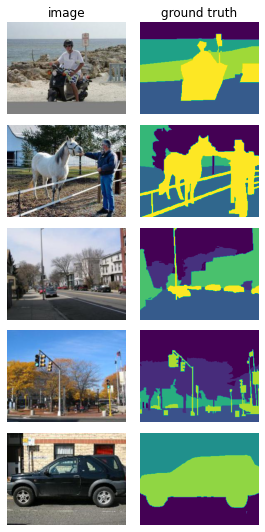

In [44]:
def view_image_gt(idxs, dataset, save_fig=False, filepath=None):
  n = len(idxs)
  _, axes = plt.subplots(n,2, figsize=(2*2,1.5*n))
  for i, idx in enumerate(idxs):
    img, gt = dataset[idx]
    axes[i][0].imshow(np.swapaxes(np.swapaxes(img, 0, 2), 0, 1))
    axes[i][1].imshow(gt[0])

    axes[i][0].axis('off')
    axes[i][1].axis('off')

  axes[0][0].set_title("image")
  axes[0][1].set_title("ground truth")

  plt.tight_layout()
  
  if save_fig:
    plt.savefig(filepath, bbox_inches='tight')
    print(f"figure saved at {filepath}")

view_image_gt(idxs_visualization, test_dataset, save_fig=False, 
              filepath=os.path.join(IMG_PATH, "scale_080_100_ratio_3_4_flip_50.png"))

## Simple Baseline (Q2)

This is a trivial semantic segmentor. For each pixel location it computes the 
distribution of the class label in the training set and uses that as the 
prediction. In other words, if a pixel is "sky" half the time and "water" the other half in the training data, you should label it as [0.5,0,0,0,0.5,0,0,0,0].

**PDF: in your pdf report the evaluation metrics (from the next question) for this simple baseline. Also visualize the output image of simple_predict (since simple_predict outputs the same segmentation regardless of input you can just report a single image)**

In [45]:
# Question 2
# Output shape: (num_classes, 224, 288)
def simple_train(num_classes, train_dataloader):
    # Your code
    # -------------------------
    model = torch.zeros(num_classes, 224, 288)

    for i, (img, gt) in enumerate(dataloader):
        for class_label in range(num_classes):
            model[class_label] += (gt[:, 0] == class_label).sum(dim=0)

    # normalize
    model /= model[:,0,0].sum()
    model = model.numpy()
    # -------------------------

    return model

# Output:
#   gt: the ground truth segmentation, shape (dataset_size, 1, 224, 288)
#   preds: the predicted segmentation class probabilities, shape (dataset_size, 9, 224, 288) 
def simple_predict(dataloader, model):
    gts, preds = [], []
    for i, batch in enumerate(dataloader):
        # Your code
        # -------------------------
        img_batch, gt_batch = batch
        
        for j in range(len(batch)):
            gts.append(gt_batch[j].numpy())
            preds.append(model)
        
        # -------------------------
    return np.array(gts), np.array(preds), list(dataset.classes)

(10, 1, 224, 288) (10, 9, 224, 288)


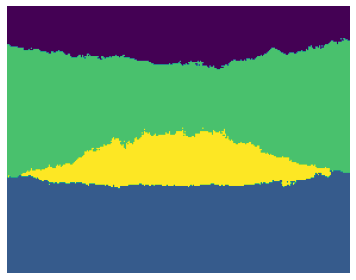

In [46]:
# our "model" is class frequency, train it then make predictions for the validation set 
class_freq = simple_train(dataset.n_classes, dataloader)
gts, preds, classes = simple_predict(val_dataloader, class_freq)

print(gts.shape, preds.shape)

# visualize the output segmentation prediction
plt.imshow(np.argmax(preds[0], axis=0))
plt.axis('off')
plt.tight_layout()
# plt.savefig(os.path.join(IMG_PATH, "simple_predict.png"), bbox_inches='tight')

## Evaluation Metrics (Q3)

We've implemented mean average precision. Your job is to compute the confusion matrix and IoU for a set of predictions. Namely, fill in the compute_confusion_matrix function.

The **(i,j)**th entry of a confusion matrix computes the number of observations known to be in group **i** and predicted to be in group **j**. You can use [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) as a reference and sanity check.

IoU is the intersection of the predicted and ground truth segmentation masks divided by their union. Think how these values are related to what you've already computed in the confusion matrix. 

In [47]:
def segmentation_eval(gts, preds, classes, plot_file_name):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    @param    plot_file_name    string          plot file names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    plot_results(counts, ious, aps, classes, plot_file_name)
    for i in range(len(classes)):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious

def plot_results(counts, ious, aps, classes, file_name):
    fig, ax = plt.subplots(1,1)
    conf = counts / np.sum(counts, 1, keepdims=True)
    conf = np.concatenate([conf, np.array(aps).reshape(-1,1), 
                           np.array(ious).reshape(-1,1)], 1)
    conf = conf * 100.
    sns.heatmap(conf, annot=True, ax=ax, fmt='3.0f') 
    arts = [] 
    # labels, title and ticks
    _ = ax.set_xlabel('Predicted labels')
    arts.append(_)
    _ = ax.set_ylabel('True labels')
    arts.append(_)
    _ = ax.set_title('Confusion Matrix, mAP: {:5.1f}, mIoU: {:5.1f}'.format(
      np.mean(aps)*100., np.mean(ious)*100.))
    arts.append(_)
    _ = ax.xaxis.set_ticklabels(classes + ['AP', 'IoU'], rotation=90)
    arts.append(_)
    _ = ax.yaxis.set_ticklabels(classes, rotation=0)
    arts.append(_)
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(file_name, bbox_inches='tight')

def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
        ap, prec, rec = calc_pr(gts == i, preds[:,i:i+1,:,:])
        aps.append(ap)
    return aps

def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1,1))
    out = out.astype(np.float64).reshape((-1,1))
    tog = np.concatenate([gt, out], axis=1)*1.
    ind = np.argsort(tog[:,1], axis=0)[::-1]
    tog = tog[ind,:]
    cumsumsortgt = np.cumsum(tog[:,0])
    cumsumsortwt = np.cumsum(tog[:,0]-tog[:,0]+1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:,0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec

def voc_ap(rec, prec):
    rec = rec.reshape((-1,1))
    prec = prec.reshape((-1,1))
    z = np.zeros((1,1)) 
    o = np.ones((1,1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0]+1;
    ap = np.sum((mrec[I] - mrec[I-1])*mpre[I])
    return ap
    
# Question 3: compute the confusion matrix and IoU metrics
# Hint: once you've computed the confusion matrix, IoU is easy
# Note: preds contains class probabilities, convert this to a class prediction
def compute_confusion_matrix(gts, preds):
    # Your code
    # --------------------------
    n_classes = 9
    conf = np.zeros((n_classes, n_classes))
    IoU = np.zeros((n_classes))
    
    gts_argmax = gts[:,0]
    preds_argmax = np.argmax(preds, axis=1)

    for i in range(n_classes):
        for j in range(n_classes):
            conf[i][j] = np.count_nonzero((gts_argmax==i)*(preds_argmax==j))
    
    IoU = conf.diagonal() / conf.sum(axis=1)
    
    # --------------------------
    return IoU, conf

                 sky: AP: 0.60, IoU: 0.63
                tree: AP: 0.15, IoU: 0.00
                road: AP: 0.52, IoU: 0.96
               grass: AP: 0.12, IoU: 0.00
               water: AP: 0.18, IoU: 0.00
            building: AP: 0.42, IoU: 0.54
            mountain: AP: 0.01, IoU: 0.00
          foreground: AP: 0.18, IoU: 0.26
                misc: AP: 0.03, IoU: 0.00
                mean: AP: 0.24, IoU: 0.27


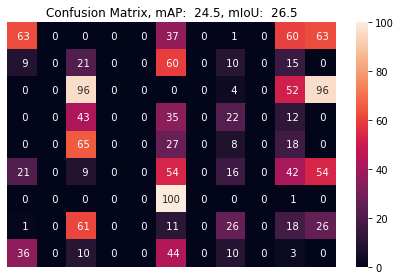

In [11]:
# Evaluate our trivial segmentor
aps, ious = segmentation_eval(gts, preds, classes, os.path.join(IMG_PATH, "eval_simple_predict.png"))

## Loss function (Q4)

Implement the weighted cross entropy loss. 

You may not call nn.CrossEntropy but can use it as a good reference and sanity check.

**PDF: in your pdf please describe the cross entropy loss. Also explain the purpose of using a weighted loss.**

In [48]:
def cross_entropy_criterion(predictions, labels, weights, device):
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    # https://gist.github.com/yang-zhang/217dcc6ae9171d7a46ce42e215c1fee0
    
    B, C, H, W = predictions.shape

    if type(predictions) is not torch.Tensor:
        predictions = torch.from_numpy(predictions)
    if type(labels) is not torch.Tensor:
        labels = torch.from_numpy(labels)

    pred = predictions.reshape(B,C,-1).to(device)
    target = labels.reshape(B,-1).to(device)

    pred = F.log_softmax(pred, dim=1)
    loss = F.nll_loss(pred, target, torch.FloatTensor(weights).to(device))

    return loss

### sanity check below!
# For the weighted cross entropy loss we can compute class weights using our simple baseline
class_freq = simple_train(dataset.n_classes, dataloader)
class_weights = []
for i in range(9):
    class_weights.append(1 / np.mean(class_freq[i, :, :]))

test_device = torch.device("cpu")
print(cross_entropy_criterion(preds, gts, class_weights, test_device))
print(nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))(torch.from_numpy(preds), torch.from_numpy(gts[:,0])).to(test_device))

tensor(2.1847)
tensor(2.1847)


## Training loop (Q5)

Fill in the training loop. We've provided validation code as well as skeleton code for training.

Keep in mind that you need to move data onto the device (GPU) as you cycle through the dataloader

While we've provided you with a skeleton to fill in, you should feel free to modify the visualization code for debugging purposes. For example you might want to print out the loss each iteration instead of once per epoch. Or you might want to compute validation accuracy metrics (like IoU) instead of just validation loss.

**PDF: in your pdf please describe why it is important to consider both validation and training losses simultaneously. When loss stops decreasing, can we change something about the training parameters to continue improving the model?**

In [49]:
def validate_model(val_loader, model, classes, device, show_matrix=False):
    preds = np.array([]).reshape(0,9,224,288)
    gts = np.array([]).reshape(0,1,224,288)
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)

            outputs = model(inputs).cpu().numpy()
            preds = np.concatenate([preds, outputs], axis=0)
            gts = np.concatenate([gts, labels.numpy()], axis=0)
            
            print("Validating...{}\r".format(100.0*len(preds)/len(val_loader)), end="")
    
    if show_matrix:
        aps, ious = segmentation_eval(gts, preds, classes, 'cs543-simple-val_3.png')
    else:
        ious, counts = compute_confusion_matrix(gts, preds)
        aps = compute_ap(gts, preds)
        for i in range(len(classes)):
            print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))

    return preds, gts

# Your goal is to complete this function
def train(model, optimizer, criterion, trainloader, device, 
          scheduler=None, epochs=100, num_early_stop=np.nan,
          valloader=None, save_path=MODEL_PATH):
    # Your code
    # -------------------------
    best_model_fname = "model_best.pth"
    best_model_path = os.path.join(save_path, best_model_fname)

    # create a directory to save checkpoints
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print("Create %s" % (save_path))
    # -------------------------

    train_loss_over_epochs = []
    val_loss_over_epochs = []
    plt.ioff()
    fig = plt.figure()
    for epoch in range(epochs):
        # running loss is the **average** loss for each item in the dataset during this epoch
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Your code
            # -------------------------
            img, gt = data
            img = img.to(device)
            gt = gt.to(device)
            
            optimizer.zero_grad()
            pred = model(img)
            loss = criterion(pred, gt).to(device)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # -------------------------
        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)
        train_loss_over_epochs.append(running_loss)
        print(f'Epoch: {epoch+1}, training loss: {running_loss:.3f}')

        # If you pass in a validation dataloader then compute the validation loss
        if not valloader is None:
            val_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    # Your code
                    # -------------------------
                    img, gt = data
                    img = img.to(device)
                    gt = gt.to(device)
                    
                    pred = model(img)
                    loss = criterion(pred, gt)
                    val_loss += loss.item()
                    # -------------------------
            # Normalizing the loss by the total number of validation batches
            val_loss /= len(valloader)
            val_loss_over_epochs.append(val_loss)
            print(f'Epoch: {epoch+1}, validation loss: {val_loss:.3f}')

            # Your code
            # -------------------------
            # step over scheduler
            if not scheduler is None:
              scheduler.step(np.mean(val_loss))

            # check whether the performance has been improved. if not, quit training
            if val_loss == min(val_loss_over_epochs):
                torch.save(model.state_dict(), best_model_path)
                print(f"Epoch: {epoch+1}, Best model saved at {best_model_path}")
                num_no_improvement = 0
            else:
                num_no_improvement += 1
                print(f"Epoch: {epoch+1}, No improvement ({num_no_improvement} / {num_early_stop})")
                if num_no_improvement >= num_early_stop:
                    break
            # -------------------------
        
    plt.subplot(1, 1, 1)
    plt.ylabel('Loss')
    plt.plot(np.arange(len(train_loss_over_epochs)), train_loss_over_epochs, color='red', label='train')
    if not valloader is None:
        plt.plot(np.arange(len(val_loss_over_epochs)), val_loss_over_epochs, color='blue', label='val')
    plt.title('Loss per Epoch')
    plt.xticks(np.arange(len(train_loss_over_epochs), dtype=int))
    plt.xticks(np.arange(len(train_loss_over_epochs), step=len(train_loss_over_epochs)//10, dtype=int))
    plt.grid(True)
    plt.legend()

    # Your code
    # -------------------------
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "loss_curve.png"))
    # -------------------------

    return model

## Model definitions (Q6)

Now create your models. Create one basic Convolutional architecture and one U-Net architecture.

We provide some helpful methods below to compute the size of your next convolutional layer (you can find these formula at TODO).

Some things to keep in mind:
- your basic layer is nn.Conv2D, read its documentation
- for UNet you will also need nn.ConvTranspose2D and Pooling layers
- nn.BatchNorm2d is incredibly helpful between layers
- you can stick to ReLU activations, but are welcome to report results with other activation functions
- the model output should be class probabilities

**PDF: in your pdf please describe your final model architectures. Report the training plots and final accuracy metrics on the validation set for each model. What batch size, learning rate, optimizer did you find works best. Perform a small ablation study: what is the effect of batchnorm on training speed and accuracy? Visualize a few images and their predicted segmentation masks by your UNet model.**

In [50]:
def conv_out_size(inp_size, kernel_size, dilation, padding, stride):
    return ((inp_size + 2*padding - dilation * (kernel_size - 1) - 1) // stride) + 1

def conv_trans_out_size(inp_size, kernel_size, dilation, padding, stride, out_padding):
    return (inp_size - 1) * stride - 2*padding + dilation * (kernel_size - 1) + out_padding + 1

print(conv_out_size(3,3,0,1,1))


5


In [51]:
# credit from https://github.com/ptrblck/pytorch_misc/blob/master/unet_demo.py


# basic CNN block consisting of convolution network + activation + batch normalization
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.batch_norm(x)
    
        return x

# CNN block for downsampling consisting of BaseConv followed by pooling (i.e., reduce tensor side length by half)
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(DownConv, self).__init__()
        self.conv_act_bn = ConvBlock(in_channels, out_channels, kernel_size, padding, stride)
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)  # reduce side of tensor by half
        
    def forward(self, x):
        x = self.pooling(x)     # reduce side of tensor by half
        x = self.conv_act_bn(x)   

        return x

# CNN block for upsampling consisting of ConvTranspose2d followed by BaseConv (i.e., increase tensor side length twice)
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UpConv, self).__init__()
        self.conv_act_bn = ConvBlock(in_channels, out_channels, kernel_size, padding, stride)
        self.conv_transpose = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, padding=0, stride=2, bias=False)  # increase side of tensor twice
        
    def forward(self, x):
        x = self.conv_transpose(x)  # increase side of tensor twice
        x = self.conv_act_bn(x)

        return x

# CNN block for upsampling with skip connection in UNet architecture, consisting of ConvTranspose2d followed by BaseConv (i.e., increase tensor side length twice)
class UnetUpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels, kernel_size=3, padding=1, stride=1):
        super(UnetUpConv, self).__init__()
        self.conv_act_bn = ConvBlock(in_channels+in_channels_skip, out_channels, kernel_size, padding, stride)
        self.conv_transpose = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, padding=0, stride=2, bias=False)  # increase side of tensor twice
        
    def forward(self, x, x_skip):
        x = self.conv_transpose(x)          # increase side of tensor twice
        x = torch.cat((x, x_skip), dim=1)   # concatenate upsampled and skipped tensor
        x = self.conv_act_bn(x)             # proceed to convnet operation

        return x

class BaseConv(nn.Module):
    def __init__(self, n_classes=9):
        super(BaseConv, self).__init__()

        in_channels = 3
        out_channels = 64

        # block for convnet operation for input tensor
        self.conv_in = ConvBlock(in_channels=in_channels, out_channels=out_channels, 
                                 kernel_size=7, padding=3, stride=2)                          # output: [B,  64, H/2, W/2]

        # blocks for convnet operation followed by downsampling
        self.conv_down1 = DownConv(in_channels=1*out_channels, out_channels=1*out_channels)   # output: [B,  64, H/4, W/4]
        self.conv_down2 = DownConv(in_channels=1*out_channels, out_channels=2*out_channels)   # output: [B, 128, H/8, W/8]
        self.conv_down3 = DownConv(in_channels=2*out_channels, out_channels=4*out_channels)   # output: [B, 256, H/16, W/16]
        self.conv_down4 = DownConv(in_channels=4*out_channels, out_channels=8*out_channels)   # output: [B, 512, H/32, W/32]

        # blocks for convnet operation preceded by upsampling
        self.conv_up4 = UpConv(in_channels=8*out_channels, out_channels=4*out_channels)       # output: [B, 256, H/16, W/16]
        self.conv_up3 = UpConv(in_channels=4*out_channels, out_channels=2*out_channels)       # output: [B, 128, H/8, W/8]
        self.conv_up2 = UpConv(in_channels=2*out_channels, out_channels=1*out_channels)       # output: [B,  64, H/4, W/4]
        self.conv_up1 = UpConv(in_channels=1*out_channels, out_channels=1*out_channels)       # output: [B,  64, H/2, W/2]
        self.conv_up0 = UpConv(in_channels=1*out_channels, out_channels=1*out_channels)       # output: [B,  64, H/1, W/1]
        
        # block for convnet operation to construct n_classes semantic outputs
        self.conv_out = nn.Conv2d(in_channels=out_channels, out_channels=n_classes, kernel_size=1, padding=0, stride=1) # output: [B, n_classes, H/1, W/1]
    
    def __repr__(self):
        return "BaseConv"
        
    def forward(self, x):
        x = self.conv_in(x)
        
        x_down1 = self.conv_down1(x)
        x_down2 = self.conv_down2(x_down1)
        x_down3 = self.conv_down3(x_down2)
        x_down4 = self.conv_down4(x_down3)
        
        x_up4 = self.conv_up4(x_down4)
        x_up3 = self.conv_up3(x_down3)
        x_up2 = self.conv_up2(x_up3)
        x_up1 = self.conv_up1(x_up2)
        x_up0 = self.conv_up1(x_up1)

        pred = self.conv_out(x_up0)

        return pred


class UNet(nn.Module):
    def __init__(self, n_classes=9):
        super(UNet, self).__init__()

        in_channels = 3
        out_channels = 64

        # block for convnet operation for input tensor
        self.conv_in = ConvBlock(in_channels=in_channels, out_channels=out_channels, 
                                 kernel_size=7, padding=3, stride=2)                          # output: [B,  64, H/2, W/2]

        # blocks for convnet operation followed by downsampling
        self.conv_down1 = DownConv(in_channels=1*out_channels, out_channels=1*out_channels)   # output: [B,  64, H/4, W/4]
        self.conv_down2 = DownConv(in_channels=1*out_channels, out_channels=2*out_channels)   # output: [B, 128, H/8, W/8]
        self.conv_down3 = DownConv(in_channels=2*out_channels, out_channels=4*out_channels)   # output: [B, 256, H/16, W/16]
        self.conv_down4 = DownConv(in_channels=4*out_channels, out_channels=8*out_channels)   # output: [B, 512, H/32, W/32]

        # blocks for convnet operation preceded by upsampling
        self.conv_up4 = UnetUpConv(in_channels=8*out_channels, in_channels_skip=4*out_channels, out_channels=4*out_channels)       # output: [B, 256, H/16, W/16]
        self.conv_up3 = UnetUpConv(in_channels=4*out_channels, in_channels_skip=2*out_channels, out_channels=2*out_channels)       # output: [B, 128, H/8, W/8]
        self.conv_up2 = UnetUpConv(in_channels=2*out_channels, in_channels_skip=1*out_channels, out_channels=1*out_channels)       # output: [B,  64, H/4, W/4]
        self.conv_up1 = UnetUpConv(in_channels=1*out_channels, in_channels_skip=1*out_channels, out_channels=1*out_channels)       # output: [B,  64, H/2, W/2]
        self.conv_up0 = UpConv(in_channels=1*out_channels, out_channels=1*out_channels)       # output: [B,  64, H/1, W/1]
        
        # block for convnet operation to construct n_classes semantic outputs
        self.conv_out = nn.Conv2d(in_channels=out_channels, out_channels=n_classes, kernel_size=1, padding=0, stride=1) # output: [B, n_classes, H/1, W/1]
    
    def __repr__(self):
        return "UNet"        

    def forward(self, x):
        x = self.conv_in(x)
        x_down1 = self.conv_down1(x)
        x_down2 = self.conv_down2(x_down1)
        x_down3 = self.conv_down3(x_down2)
        x_down4 = self.conv_down4(x_down3)

        x_up4 = self.conv_up4(x_down4, x_down3)
        x_up3 = self.conv_up3(x_up4, x_down2)
        x_up2 = self.conv_up2(x_up3, x_down1)
        x_up1 = self.conv_up1(x_up2, x)
        x_up0 = self.conv_up0(x_up1)

        pred = self.conv_out(x_up0)

        return pred

In [52]:
# backup below
class BaseConvOld(nn.Module):
    def __init__(self, n_classes=9):
        super(BaseConvOld, self).__init__()

        in_channels = 3
        out_channels = 64

        # block for convnet operation for input tensor
        self.conv_in = ConvBlock(in_channels=in_channels, out_channels=out_channels)          # output: [N,  64, H, W]

        # blocks for convnet operation followed by downsampling
        self.conv_down1 = DownConv(in_channels=1*out_channels, out_channels=1*out_channels)   # output: [N,  64, H/2, W/2]
        self.conv_down2 = DownConv(in_channels=2*out_channels, out_channels=4*out_channels)   # output: [N, 256, H/4, W/4]
        self.conv_down3 = DownConv(in_channels=4*out_channels, out_channels=8*out_channels)   # output: [N, 512, H/8, W/8]

        # blocks for convnet operation preceded by upsampling
        self.conv_up3 = UpConv(in_channels=8*out_channels, out_channels=4*out_channels)       # output: [N, 256, H/4, W/4]
        self.conv_up2 = UpConv(in_channels=4*out_channels, out_channels=2*out_channels)       # output: [N, 128, H/2, W/2]
        self.conv_up1 = UpConv(in_channels=2*out_channels, out_channels=1*out_channels)       # output: [N,  64, H/1, W/1]
        
        # block for convnet operation to construct n_classes semantic outputs
        self.conv_out = nn.Conv2d(in_channels=out_channels, out_channels=n_classes, kernel_size=1, padding=0, stride=1)
    
    def __repr__(self):
        return "BaseConvOld"
        
    def forward(self, x):
        x = self.conv_in(x)
        
        x_down1 = self.conv_down1(x)
        x_down2 = self.conv_down2(x_down1)
        x_down3 = self.conv_down3(x_down2)
        
        x_up3 = self.conv_up3(x_down3)
        x_up2 = self.conv_up2(x_up3)
        x_up1 = self.conv_up1(x_up2)

        pred = self.conv_out(x_up1)

        return pred


class UNetOld(nn.Module):
    def __init__(self, n_classes=9):
        super(UNetOld, self).__init__()

        in_channels = 3
        out_channels = 64

        # block for convnet operation for input tensor
        self.conv_in = ConvBlock(in_channels=in_channels, out_channels=out_channels)

        # blocks for convnet operation followed by downsampling
        self.conv_down1 = DownConv(in_channels=1*out_channels, out_channels=2*out_channels)
        self.conv_down2 = DownConv(in_channels=2*out_channels, out_channels=4*out_channels)
        self.conv_down3 = DownConv(in_channels=4*out_channels, out_channels=8*out_channels)

        # blocks for convnet operation preceded by upsampling
        self.conv_up3 = UnetUpConv(in_channels=8*out_channels, in_channels_skip=4*out_channels, out_channels=4*out_channels)
        self.conv_up2 = UnetUpConv(in_channels=4*out_channels, in_channels_skip=2*out_channels, out_channels=2*out_channels)
        self.conv_up1 = UnetUpConv(in_channels=2*out_channels, in_channels_skip=1*out_channels, out_channels=1*out_channels)
        
        # block for convnet operation to construct n_classes semantic outputs
        self.conv_out = nn.Conv2d(in_channels=out_channels, out_channels=n_classes, kernel_size=1, padding=0, stride=1)

    def __repr__(self):
        return "UNetOld"        

    def forward(self, x):
        x = self.conv_in(x)
        
        x_down1 = self.conv_down1(x)
        x_down2 = self.conv_down2(x_down1)
        x_down3 = self.conv_down3(x_down2)
        
        x_up3 = self.conv_up3(x_down3, x_down2)
        x_up2 = self.conv_up2(x_up3, x_down1)
        x_up1 = self.conv_up1(x_up2, x)

        pred = self.conv_out(x_up1)
        
        return pred

In [53]:
x = torch.Tensor(size=(10,3,32,32))
base_model = BaseConv()
unet_model = UNet()

print(base_model(x).size())
print(unet_model(x).size())

torch.Size([10, 9, 32, 32])
torch.Size([10, 9, 32, 32])


### Now we can finally train our models...

In [54]:
# if runtime has GPU use GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [55]:
# For the weighted cross entropy loss we can compute class weights using our simple baseline
class_freq = simple_train(dataset.n_classes, dataloader)
class_weights = []
for i in range(9):
    class_weights.append(1 / np.mean(class_freq[i, :, :]))
print(class_weights)

[7.309973844425089, 6.903079168991391, 4.614186936383786, 14.162880953071868, 26.236360140895275, 4.467769170006787, 71.44255130129898, 6.639241022280368, 224.69834454392168]


### Basic convolutional model training

In [ ]:
# First make the model and put it on the device
base_model = BaseConv().to(device)

# Now define our loss criterion as cross entropy based on your previous code
#criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights, device)

# Now make our optimizer for this model
lr = 1e-3
optimizer = optim.SGD(base_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=False)
scheduler = None

# Now train and validate
epochs = 50
num_early_stop = np.nan
base_model = train(base_model, optimizer, criterion, dataloader, device, 
                   valloader=val_dataloader, save_path=os.path.join(MODEL_PATH, str(base_model)),
                   epochs=epochs, scheduler=scheduler, num_early_stop=num_early_stop)
preds, gts = validate_model(val_dataloader, base_model, list(dataset.classes), device)

#### UNet model training

In [ ]:
# First make the model and put it on the device
unet_model = UNet().to(device)

# Now define our loss criterion as cross entropy based on your previous code
#criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights, device)

# Now make our optimizer for this model
lr = 1e-3
optimizer = optim.SGD(unet_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=False)
scheduler = None

# Now train and validate
epochs = 50
num_early_stop = np.nan
unet_model = train(unet_model, optimizer, criterion, dataloader, device, 
                   valloader=val_dataloader, save_path=os.path.join(MODEL_PATH, str(unet_model)),
                   epochs=epochs, scheduler=scheduler, num_early_stop=num_early_stop)
preds, gts = validate_model(val_dataloader, unet_model, list(dataset.classes), device)

Make sure to report the results for both models. 

## Working off a pretrained model (Q7)

Finally, you will now modify a pretrained model (resnet18) and use it as an initialization for training. You should be able to get better results with this model than before.

You can finetune (meaning backpropagate through the resnet layers) or not. You can finetune just some layers and not others. It's up to you.

**PDF: in your pdf report the final accuracy of your model based on a pretrained model. Describe how you used the pretrained model, which features did you extract and why?**

In [56]:
class ResnetBasedModel(nn.Module):
    def __init__(self, pretrained_resnet, num_layers_to_remove=0, n_classes=9):
        super(ResnetBasedModel, self).__init__()
        # You can, for example, extract the first N layers of the model like this:
        # self.resnet_features = nn.Sequential(*list(pretrained_resnet.children())[:N])
        
        out_channels = 64

        resnet_layers = list(pretrained_resnet.children())

        # blocks for convnet operation followed by downsampling
        self.conv_in = nn.Sequential(*resnet_layers[:3])              # output: [B,  64, H/2, W/2]
        self.conv_down1 = nn.Sequential(*resnet_layers[3:5])          # output: [B,  64, H/4, W/4]
        self.conv_down2 = resnet_layers[5]                            # output: [B, 128, H/8, W/8]
        self.conv_down3 = resnet_layers[6]                            # output: [B, 256, H/16, W/16]
        self.conv_down4 = resnet_layers[7]                            # output: [B, 512, H/32, W/32]

        # blocks for convnet operation preceded by upsampling, without skip connection
        self.conv_up4 = UpConv(in_channels=8*out_channels, out_channels=4*out_channels)      # output: [B, 256, H/16, W/16]
        self.conv_up3 = UpConv(in_channels=4*out_channels, out_channels=2*out_channels)      # output: [B, 128, H/8, W/8]
        self.conv_up2 = UpConv(in_channels=2*out_channels, out_channels=1*out_channels)      # output: [B,  64, H/4, W/4]
        self.conv_up1 = UpConv(in_channels=1*out_channels, out_channels=1*out_channels)      # output: [B,  64, H/2, W/2]
        self.conv_up0 = UpConv(in_channels=1*out_channels, out_channels=1*out_channels)      # output: [B,  64, H/1, W/1]

        # block for convnet operation to construct n_classes semantic outputs
        self.conv_out = nn.Conv2d(in_channels=out_channels, out_channels=n_classes, kernel_size=1, padding=0, stride=1)
    
    def __repr__(self):
        return "ResnetBasedModel"        

    def forward(self, x):
        x = self.conv_in(x)
        x_down1 = self.conv_down1(x)
        x_down2 = self.conv_down2(x_down1)
        x_down3 = self.conv_down3(x_down2)
        x_down4 = self.conv_down4(x_down3)

        x_up4 = self.conv_up4(x_down4)
        x_up3 = self.conv_up3(x_up4)
        x_up2 = self.conv_up2(x_up3)
        x_up1 = self.conv_up1(x_up2)
        x_up0 = self.conv_up0(x_up1)

        pred = self.conv_out(x_up0)

        return pred

class ResnetUNetModel(nn.Module):
    def __init__(self, pretrained_resnet, num_layers_to_remove=0, n_classes=9):
        super(ResnetUNetModel, self).__init__()
        # You can, for example, extract the first N layers of the model like this:
        # self.resnet_features = nn.Sequential(*list(pretrained_resnet.children())[:N])
        
        out_channels = 64

        resnet_layers = list(pretrained_resnet.children())

        # blocks for convnet operation followed by downsampling
        self.conv_in = nn.Sequential(*resnet_layers[:3])              # output: [B,  64, H/2, W/2]
        self.conv_down1 = nn.Sequential(*resnet_layers[3:5])          # output: [B,  64, H/4, W/4]
        self.conv_down2 = resnet_layers[5]                            # output: [B, 128, H/8, W/8]
        self.conv_down3 = resnet_layers[6]                            # output: [B, 256, H/16, W/16]
        self.conv_down4 = resnet_layers[7]                            # output: [B, 512, H/32, W/32]

        # blocks for convnet operation preceded by upsampling, with skip connection
        self.conv_up4 = UnetUpConv(in_channels=8*out_channels, in_channels_skip=4*out_channels, out_channels=4*out_channels)     # output: [B, 256, H/16, W/16]
        self.conv_up3 = UnetUpConv(in_channels=4*out_channels, in_channels_skip=2*out_channels, out_channels=2*out_channels)     # output: [B, 128, H/8, W/8]     
        self.conv_up2 = UnetUpConv(in_channels=2*out_channels, in_channels_skip=1*out_channels, out_channels=1*out_channels)     # output: [B,  64, H/4, W/4]
        self.conv_up1 = UnetUpConv(in_channels=1*out_channels, in_channels_skip=1*out_channels, out_channels=1*out_channels)     # output: [B,  64, H/2, W/2]
        self.conv_up0 = UpConv(in_channels=1*out_channels, out_channels=1*out_channels)                                          # output: [B,  64, H/1, W/1]

        # block for convnet operation to construct n_classes semantic outputs
        self.conv_out = nn.Conv2d(in_channels=out_channels, out_channels=n_classes, kernel_size=1, padding=0, stride=1)
    
    def __repr__(self):
        return "ResnetUNetModel"        

    def forward(self, x):
        x = self.conv_in(x)
        x_down1 = self.conv_down1(x)
        x_down2 = self.conv_down2(x_down1)
        x_down3 = self.conv_down3(x_down2)
        x_down4 = self.conv_down4(x_down3)

        x_up4 = self.conv_up4(x_down4, x_down3)
        x_up3 = self.conv_up3(x_up4, x_down2)
        x_up2 = self.conv_up2(x_up3, x_down1)
        x_up1 = self.conv_up1(x_up2, x)
        x_up0 = self.conv_up0(x_up1)

        pred = self.conv_out(x_up0)

        return pred

Create ./model/ResnetBasedModel/
Epoch: 1, training loss: 2.197
Epoch: 1, validation loss: 2.094
Epoch: 1, Best model saved at ./model/ResnetBasedModel/model_best.pth
Epoch: 2, training loss: 1.822
Epoch: 2, validation loss: 1.753
Epoch: 2, Best model saved at ./model/ResnetBasedModel/model_best.pth
Epoch: 3, training loss: 1.518
Epoch: 3, validation loss: 1.600
Epoch: 3, Best model saved at ./model/ResnetBasedModel/model_best.pth
Epoch: 4, training loss: 1.394
Epoch: 4, validation loss: 1.530
Epoch: 4, Best model saved at ./model/ResnetBasedModel/model_best.pth
Epoch: 5, training loss: 1.320
Epoch: 5, validation loss: 1.517
Epoch: 5, Best model saved at ./model/ResnetBasedModel/model_best.pth
Epoch: 6, training loss: 1.240
Epoch: 6, validation loss: 1.358
Epoch: 6, Best model saved at ./model/ResnetBasedModel/model_best.pth
Epoch: 7, training loss: 1.167
Epoch: 7, validation loss: 1.287
Epoch: 7, Best model saved at ./model/ResnetBasedModel/model_best.pth
Epoch: 8, training loss: 1.08

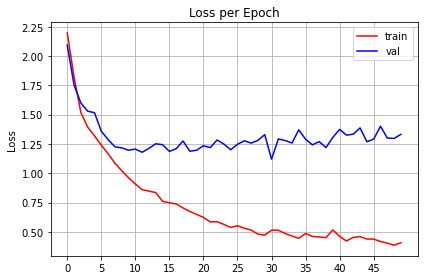

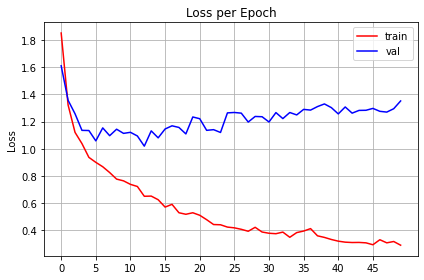

In [ ]:
# First make the model and put it on the device
pretrained_resnet = models.resnet18(pretrained=True)
resnet_based_model = ResnetBasedModel(pretrained_resnet).to(device)

# Now define our loss criterion as cross entropy based on your previous code
#criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights, device)

# Now make our optimizer for this model
lr = 1e-3
optimizer = optim.SGD(resnet_based_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
#optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=False)
scheduler = None

# Now train and validate
epochs = 50
num_early_stop = np.nan
resnet_based_model = train(resnet_based_model, optimizer, criterion, dataloader, device, 
                   valloader=val_dataloader, save_path=os.path.join(MODEL_PATH, str(resnet_based_model)),
                   epochs=epochs, scheduler=scheduler, num_early_stop=num_early_stop)
preds, gts = validate_model(val_dataloader, resnet_based_model, list(dataset.classes), device)


#####################################################################
# First make the model and put it on the device
pretrained_resnet = models.resnet18(pretrained=True)
resnet_unet_model = ResnetUNetModel(pretrained_resnet).to(device)

# Now define our loss criterion as cross entropy based on your previous code
#criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights, device)

# Now make our optimizer for this model
lr = 1e-3
optimizer = optim.SGD(resnet_unet_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
#optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=False)
scheduler = None

# Now train and validate
epochs = 50
num_early_stop = np.nan
resnet_unet_model = train(resnet_unet_model, optimizer, criterion, dataloader, device,
                   valloader=val_dataloader, save_path=os.path.join(MODEL_PATH, str(resnet_unet_model)),
                   epochs=epochs, scheduler=scheduler, num_early_stop=num_early_stop)
preds, gts = validate_model(val_dataloader, resnet_unet_model, list(dataset.classes), device)

# Test set

Finally we can check evaluation on test set....

**PDF: in your pdf report the results of your best model (this should be based on a pretrained model) on the test dataset.**

In [77]:
model = UNet().to(device)
# model = ResnetBasedModel(models.resnet18(pretrained=True)).to(device)

model_path = os.path.join(MODEL_PATH, str(model), "model_best.pth")
model.load_state_dict(torch.load(model_path))

preds, gts = validate_model(test_dataloader, model, list(dataset.classes), device)

                 sky: AP: 0.95, IoU: 0.87
                tree: AP: 0.74, IoU: 0.75
                road: AP: 0.93, IoU: 0.81
               grass: AP: 0.72, IoU: 0.77
               water: AP: 0.29, IoU: 0.57
            building: AP: 0.74, IoU: 0.65
            mountain: AP: 0.06, IoU: 0.27
          foreground: AP: 0.68, IoU: 0.65
                misc: AP: 0.01, IoU: 0.09
                mean: AP: 0.57, IoU: 0.60


figure saved at /content/gdrive/My Drive/Colab Notebooks/CS_498_MP4/imgs/UNet.png


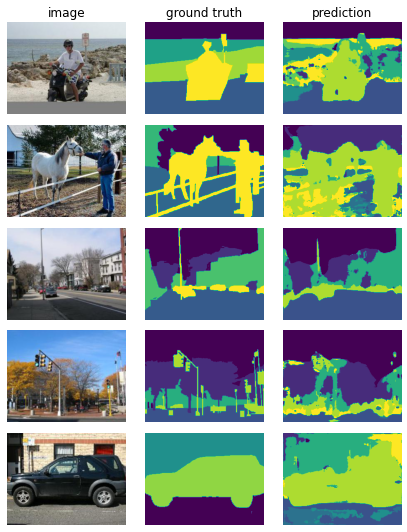

In [78]:
def view_image_gt_pred(idxs, dataset, pred, save_fig=False, filepath=None):
  n = len(idxs)
  _, axes = plt.subplots(n,3, figsize=(2*3,1.5*n))
  for i, idx in enumerate(idxs):
    img, gt = dataset[idx]
    axes[i][0].imshow(np.swapaxes(np.swapaxes(img, 0, 2), 0, 1))
    axes[i][1].imshow(gt[0])
    axes[i][2].imshow(np.argmax(pred[idx], axis=0))

    axes[i][0].axis('off')
    axes[i][1].axis('off')
    axes[i][2].axis('off')

  axes[0][0].set_title("image")
  axes[0][1].set_title("ground truth")
  axes[0][2].set_title("prediction")

  plt.tight_layout()
  
  if save_fig:
    plt.savefig(filepath, bbox_inches='tight')
    print(f"figure saved at {filepath}")

view_image_gt_pred(idxs_visualization, test_dataset, preds, save_fig=True, 
                   filepath=os.path.join(IMG_PATH, f"{str(model)}.png"))